In [1]:
import quandl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
from math import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

### Dynamic Nelson-Siegel approach

In [2]:
df = quandl.get("USTREASURY/YIELD")
df= df.loc['2011-06-01':'2016-12-30', :].drop(["1 MO",'2 MO'], 1)
df.head(), df.tail()

(            3 MO  6 MO  1 YR  2 YR  3 YR  5 YR  7 YR  10 YR  20 YR  30 YR
 Date                                                                     
 2011-06-01  0.05  0.11  0.18  0.44  0.74  1.60  2.28   2.96   3.83   4.15
 2011-06-02  0.04  0.11  0.19  0.45  0.78  1.65  2.34   3.04   3.92   4.25
 2011-06-03  0.04  0.10  0.18  0.42  0.75  1.60  2.28   2.99   3.90   4.22
 2011-06-06  0.05  0.10  0.18  0.43  0.74  1.60  2.29   3.01   3.92   4.25
 2011-06-07  0.05  0.11  0.18  0.39  0.74  1.59  2.29   3.01   3.94   4.27,
             3 MO  6 MO  1 YR  2 YR  3 YR  5 YR  7 YR  10 YR  20 YR  30 YR
 Date                                                                     
 2016-12-23  0.52  0.65  0.87  1.22  1.54  2.04  2.35   2.55   2.86   3.12
 2016-12-27  0.51  0.66  0.89  1.28  1.58  2.07  2.37   2.57   2.88   3.14
 2016-12-28  0.53  0.62  0.90  1.26  1.55  2.02  2.32   2.51   2.83   3.09
 2016-12-29  0.47  0.62  0.85  1.22  1.49  1.96  2.30   2.49   2.82   3.08
 2016-12-30  0.51  0.62 

### 1.1 Fixed $\lambda$, and fit $\beta_1 (t)$, $\beta_2 (t)$ and $\beta_3 (t)$

In [3]:
def fixed_lambda(df, lda, cmt_terms):
    
    """ 
    Parameters
    ----------
    df -> Data frame
    lda -> Lambda
    cmt_terms -> maturities
   
    Returns
    ----------
    Dataframe with estimators and y_hat    
    """ 
    loadings = np.zeros((len(cmt_terms), 2)) 
    for x,y in zip(range(len(cmt_terms)), cmt_terms):
        loadings[x , 0]= (1-exp(-lda*y))/(lda*y)
        loadings[x , 1]= (1-exp(-lda*y))/(lda*y) - exp(-lda*y)
    
    index=df.index
    b1=[]
    b2=[]
    b3=[]
    y_pred=[]
    rmse=[]
    
    for d in index:
        y=df.loc[d, :]
        regressor = LinearRegression()  
        regressor.fit(loadings, y)
        b1.append(regressor.intercept_)
        b2.append(regressor.coef_[0])
        b3.append(regressor.coef_[1])
        y_pred.append(regressor.predict(loadings))
        rmse.append(np.sqrt(mean_squared_error(y, regressor.predict(loadings))))
    
    df_reg_coef = pd.DataFrame({ "b1":b1,"b2":b2,"b3":b3, "rmse": rmse})
    df_reg_coef.index=df.index
      
    df_reg_pred=pd.DataFrame(y_pred, columns=df.columns)   
    df_reg_pred.index=df.index
        
    return df_reg_coef,df_reg_pred

In [4]:
lda=1
cmt_terms=[3/12, 6/12, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0]
reg=fixed_lambda(df, lda, cmt_terms)

#### Coefficients

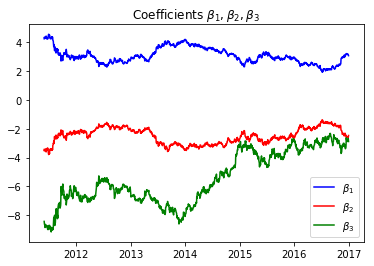

In [9]:
plt.plot(reg[0].loc[:,"b1"], label=r'$ \beta_1 $',color="b")
plt.plot(reg[0].loc[:,"b2"], label=r'$ \beta_2 $',color='r')
plt.plot(reg[0].loc[:,"b3"], label=r'$ \beta_3 $',color="g")
plt.title(r'Coefficients $\beta_1, \beta_2, \beta_3$')
plt.legend(loc=0)
plt.show()

#### Yield Curve Actual vs. Fitted, $\lambda=1$

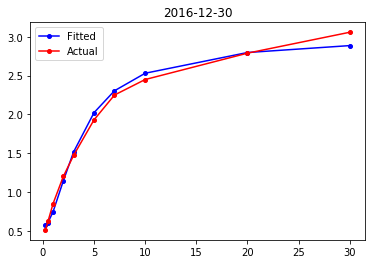

In [10]:
y_pred=reg[1]
plt.plot(cmt_terms,y_pred.loc["2016-12-30",:], "bo-", markersize=4, label="Fitted")
plt.plot(cmt_terms,df.loc["2016-12-30",:], "ro-", markersize=4, label="Actual")
plt.title("2016-12-30")
plt.legend(loc=0)
plt.show()

### 1.2 Optimal $\lambda$ that best fit the whole data set

In [11]:
def best_lambda(df, lmda, cmt_terms):
    """ 
    Parameters
    ----------
    df -> Data frame
    lda -> Lambda
    cmt_terms -> maturities
   
    Returns
    ----------
    Lowest RMSE of the sample and optimal lambda    
    """    
    best_rmse = np.inf
    best_lambda = 0
    
    for l in lmda:
        rmse=fixed_lambda(df, l, cmt_terms)[0].loc[:,"rmse"].cumsum()[-1]
        if best_rmse > rmse > 0:
                    best_rmse = rmse
                    best_lambda = l
    
    return (best_rmse, best_lambda)

In [12]:
lmda=np.arange(0.2,0.7,0.001)
bl=best_lambda(df, lmda, cmt_terms)

In [13]:
print("Optimal Lambda: {}".format(bl[1]))

Optimal Lambda: 0.4420000000000002


#### Coefficients

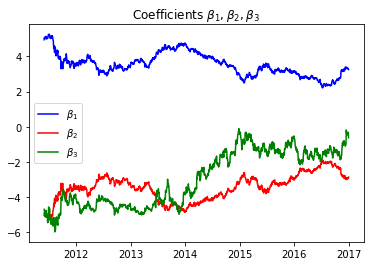

In [14]:
reg_opt=fixed_lambda(df, bl[1], cmt_terms)
plt.plot(reg_opt[0].loc[:,"b1"], label=r'$ \beta_1 $',color="b")
plt.plot(reg_opt[0].loc[:,"b2"], label=r'$ \beta_2 $',color='r')
plt.plot(reg_opt[0].loc[:,"b3"], label=r'$ \beta_3 $',color="g")
plt.title(r'Coefficients $\beta_1, \beta_2, \beta_3$')
plt.legend(loc=0)
plt.show()

#### Yield Curve Actual vs. Fitted, $\lambda=0.44$

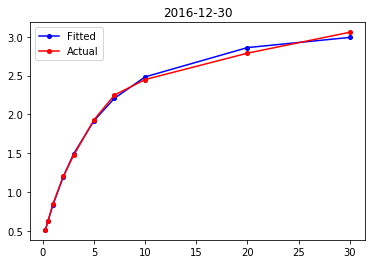

In [15]:
y_pred=reg_opt[1]
plt.plot(cmt_terms,y_pred.loc["2016-12-30",:], "bo-", markersize=4, label="Fitted")
plt.plot(cmt_terms,df.loc["2016-12-30",:], "ro-", markersize=4, label="Actual")
plt.title("2016-12-30")
plt.legend(loc=0)
plt.show()

### 2.1 Compute RMSE for each day in the sample and pick 20 days with largest RMSE

In [16]:
optimal_lambda=bl[1]
reg_opt=fixed_lambda(df, optimal_lambda, cmt_terms)

In [17]:
rmse=reg_opt[0].sort_values('rmse', ascending=False).head(20)
rmse["rmse"]

Date
2013-12-31    0.138163
2013-12-24    0.133083
2013-12-27    0.132611
2014-01-02    0.132081
2013-12-30    0.130809
2014-01-03    0.126605
2013-12-23    0.126413
2013-12-19    0.125947
2013-12-26    0.125776
2013-12-20    0.122852
2014-04-21    0.122551
2014-01-08    0.122114
2014-01-06    0.121486
2014-04-24    0.121114
2014-04-17    0.120247
2014-04-22    0.119362
2014-04-28    0.119262
2014-04-25    0.118882
2014-04-23    0.117200
2014-04-03    0.116925
Name: rmse, dtype: float64

### 2.2 Use 6m of data prior to each of the 20 days to fit AR(1) to each of $\beta_1 (t)$, $\beta_2 (t)$ and $\beta_3 (t)$ time series and compute half-lives

In [18]:
dt_index=rmse.index
dt_index

DatetimeIndex(['2013-12-31', '2013-12-24', '2013-12-27', '2014-01-02',
               '2013-12-30', '2014-01-03', '2013-12-23', '2013-12-19',
               '2013-12-26', '2013-12-20', '2014-04-21', '2014-01-08',
               '2014-01-06', '2014-04-24', '2014-04-17', '2014-04-22',
               '2014-04-28', '2014-04-25', '2014-04-23', '2014-04-03'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [19]:
def AR_1(df, dt, ndays, p,d,q):
    
    """ 
    Parameters
    ----------
    df -> Data frame
    dt -> End date
    ndays -> Forecasted days
   
    Returns
    ----------
    AR(1) forecast  
    """
    
    date=pd.date_range(end = dt, periods = 2,freq = "6M")
    start_date=date[0].strftime('%Y-%m-%d')
    
    betas=df.loc[start_date:dt,:]
    initial_value=[]
    forecast=[]
    hl=[]
    
    df_test=df.loc[dt:,:].index
    test_index=df_test[0:ndays+1].strftime('%Y-%m-%d')
    
    for col in betas.columns:
        coeff=betas[col].values
        model = ARIMA(coeff, order=(p,d,q))
        model_fit= model.fit(disp=0, solver= 'bfgs')
        
        if p !=0:
            h = -log(2)/log(model_fit.arparams)
            hl.append(h)
        
        fc_initial=model_fit.predict()
        initial_value.append(fc_initial[-1])
        fc= model_fit.forecast(ndays)[0]
        forecast.append(fc)
    
    half_lives=pd.DataFrame()
    if p !=0:
        half_lives=pd.DataFrame(hl).T
        half_lives.columns=["b1","b2","b3"]
    fc_today = pd.DataFrame(initial_value).T
    fc_series = pd.DataFrame(forecast).T
    forecast= fc_today.append(fc_series, ignore_index=True)
    forecast.columns=["b1","b2","b3"]
    forecast.index=test_index
    
    return forecast, half_lives

#### ARIMA(1,0,0) = first-order autoregressive model

In [20]:
df_betas=reg_opt[0].loc[:, "b1":"b3"]

### Half-lives

In [22]:
n_days=1
for d,i in zip(dt_index, range(1,len(dt_index)+1)):
    ar_hl=AR_1(df_betas, d, n_days, 1,0,0)
    print("{}. Half-life: {}".format(i,d.strftime('%Y-%m-%d')))
    print(ar_hl[1])
    print("--------------------------------------------- \n")

1. Half-life: 2013-12-31
          b1         b2         b3
0  14.885375  12.299844  15.174748
--------------------------------------------- 

2. Half-life: 2013-12-24
          b1         b2         b3
0  35.955027  36.447171  13.288195
--------------------------------------------- 

3. Half-life: 2013-12-27
          b1         b2         b3
0  39.571837  40.173026  13.157686
--------------------------------------------- 

4. Half-life: 2014-01-02
          b1         b2         b3
0  13.927198  11.635376  15.270195
--------------------------------------------- 

5. Half-life: 2013-12-30
          b1         b2         b3
0  37.311747  37.324889  13.139486
--------------------------------------------- 

6. Half-life: 2014-01-03
          b1        b2         b3
0  14.182242  11.92302  15.602784
--------------------------------------------- 

7. Half-life: 2013-12-23
          b1        b2         b3
0  33.451095  33.42815  13.030601
--------------------------------------------- 

8. 

### $t+5d$ forecast

In [23]:
n_days=5
for d in dt_index:
    ar_hl=AR_1(df_betas, d, n_days,1,0,0)
    print("Initial date: {}".format(d.strftime('%Y-%m-%d')))
    print(ar_hl[0])
    print("--------------------------------------------- \n")

Initial date: 2013-12-31
                  b1        b2        b3
2013-12-31  4.678108 -4.760930 -3.834976
2014-01-02  4.751061 -4.840711 -3.878755
2014-01-03  4.738756 -4.822953 -3.888092
2014-01-06  4.727011 -4.806168 -3.897012
2014-01-07  4.715800 -4.790303 -3.905534
2014-01-08  4.705099 -4.775307 -3.913675
--------------------------------------------- 

Initial date: 2013-12-24
                  b1        b2        b3
2013-12-24  4.611886 -4.697031 -3.777649
2013-12-26  4.672465 -4.771861 -3.744439
2013-12-27  4.666549 -4.764309 -3.765576
2013-12-30  4.660746 -4.756899 -3.785639
2013-12-31  4.655054 -4.749630 -3.804681
2014-01-02  4.649470 -4.742497 -3.822756
--------------------------------------------- 

Initial date: 2013-12-27
                  b1        b2        b3
2013-12-27  4.688003 -4.788716 -3.728864
2013-12-30  4.724692 -4.825607 -3.815956
2013-12-31  4.718601 -4.818035 -3.833799
2014-01-02  4.712615 -4.810594 -3.850727
2014-01-03  4.706734 -4.803279 -3.866787
2014-01-0

### $t+10d$

In [24]:
n_days=10
for d in dt_index:
    ar_hl=AR_1(df_betas, d, n_days,1,0,0)
    print("Initial date: {}".format(d.strftime('%Y-%m-%d')))
    print(ar_hl[0])
    print("--------------------------------------------- \n")

Initial date: 2013-12-31
                  b1        b2        b3
2013-12-31  4.678108 -4.760930 -3.834976
2014-01-02  4.751061 -4.840711 -3.878755
2014-01-03  4.738756 -4.822953 -3.888092
2014-01-06  4.727011 -4.806168 -3.897012
2014-01-07  4.715800 -4.790303 -3.905534
2014-01-08  4.705099 -4.775307 -3.913675
2014-01-09  4.694885 -4.761133 -3.921453
2014-01-10  4.685136 -4.747736 -3.928883
2014-01-13  4.675830 -4.735073 -3.935982
2014-01-14  4.666948 -4.723104 -3.942764
2014-01-15  4.658469 -4.711790 -3.949243
--------------------------------------------- 

Initial date: 2013-12-24
                  b1        b2        b3
2013-12-24  4.611886 -4.697031 -3.777649
2013-12-26  4.672465 -4.771861 -3.744439
2013-12-27  4.666549 -4.764309 -3.765576
2013-12-30  4.660746 -4.756899 -3.785639
2013-12-31  4.655054 -4.749630 -3.804681
2014-01-02  4.649470 -4.742497 -3.822756
2014-01-03  4.643994 -4.735498 -3.839913
2014-01-06  4.638621 -4.728631 -3.856197
2014-01-07  4.633352 -4.721894 -3.871654


Initial date: 2014-04-22
                  b1        b2        b3
2014-04-22  4.129581 -4.323385 -2.541682
2014-04-23  4.091473 -4.300419 -2.382964
2014-04-24  4.098989 -4.310415 -2.394493
2014-04-25  4.106304 -4.319833 -2.405906
2014-04-28  4.113425 -4.328709 -2.417205
2014-04-29  4.120355 -4.337073 -2.428391
2014-04-30  4.127101 -4.344954 -2.439465
2014-05-01  4.133667 -4.352381 -2.450427
2014-05-02  4.140058 -4.359379 -2.461280
2014-05-05  4.146279 -4.365974 -2.472024
2014-05-06  4.152333 -4.372188 -2.482660
--------------------------------------------- 

Initial date: 2014-04-28
                  b1        b2        b3
2014-04-28  4.036456 -4.247875 -2.388124
2014-04-29  4.067140 -4.275746 -2.424945
2014-04-30  4.074077 -4.285955 -2.435892
2014-05-01  4.080848 -4.295613 -2.446731
2014-05-02  4.087458 -4.304751 -2.457462
2014-05-05  4.093911 -4.313396 -2.468087
2014-05-06  4.100210 -4.321575 -2.478607
2014-05-07  4.106359 -4.329313 -2.489022
2014-05-08  4.112362 -4.336634 -2.499335


### $t+30d$

In [25]:
n_days=30
for d in dt_index:
    ar_hl=AR_1(df_betas, d, n_days,1,0,0)
    print("Initial date: {}".format(d.strftime('%Y-%m-%d')))
    print(ar_hl[0])
    print("--------------------------------------------- \n")

Initial date: 2013-12-31
                  b1        b2        b3
2013-12-31  4.678108 -4.760930 -3.834976
2014-01-02  4.751061 -4.840711 -3.878755
2014-01-03  4.738756 -4.822953 -3.888092
2014-01-06  4.727011 -4.806168 -3.897012
2014-01-07  4.715800 -4.790303 -3.905534
2014-01-08  4.705099 -4.775307 -3.913675
2014-01-09  4.694885 -4.761133 -3.921453
2014-01-10  4.685136 -4.747736 -3.928883
2014-01-13  4.675830 -4.735073 -3.935982
2014-01-14  4.666948 -4.723104 -3.942764
2014-01-15  4.658469 -4.711790 -3.949243
2014-01-16  4.650377 -4.701097 -3.955432
2014-01-17  4.642653 -4.690989 -3.961346
2014-01-21  4.635280 -4.681436 -3.966995
2014-01-22  4.628243 -4.672405 -3.972392
2014-01-23  4.621525 -4.663870 -3.977548
2014-01-24  4.615114 -4.655802 -3.982474
2014-01-27  4.608994 -4.648177 -3.987180
2014-01-28  4.603153 -4.640969 -3.991676
2014-01-29  4.597577 -4.634156 -3.995971
2014-01-30  4.592255 -4.627717 -4.000074
2014-01-31  4.587175 -4.621630 -4.003994
2014-02-03  4.582326 -4.615877 -

Initial date: 2013-12-23
                  b1        b2        b3
2013-12-23  4.578142 -4.655190 -3.825879
2013-12-24  4.611290 -4.696182 -3.778379
2013-12-26  4.605955 -4.689219 -3.798500
2013-12-27  4.600728 -4.682399 -3.817579
2013-12-30  4.595609 -4.675718 -3.835670
2013-12-31  4.590595 -4.669175 -3.852823
2014-01-02  4.585684 -4.662767 -3.869088
2014-01-03  4.580873 -4.656489 -3.884510
2014-01-06  4.576161 -4.650341 -3.899133
2014-01-07  4.571546 -4.644319 -3.912999
2014-01-08  4.567025 -4.638420 -3.926147
2014-01-09  4.562597 -4.632642 -3.938613
2014-01-10  4.558260 -4.626983 -3.950433
2014-01-13  4.554012 -4.621440 -3.961642
2014-01-14  4.549851 -4.616011 -3.972269
2014-01-15  4.545775 -4.610693 -3.982346
2014-01-16  4.541783 -4.605485 -3.991901
2014-01-17  4.537873 -4.600383 -4.000961
2014-01-21  4.534043 -4.595386 -4.009552
2014-01-22  4.530291 -4.590492 -4.017698
2014-01-23  4.526617 -4.585697 -4.025421
2014-01-24  4.523017 -4.581002 -4.032745
2014-01-27  4.519492 -4.576403 -

Initial date: 2014-01-06
                  b1        b2        b3
2014-01-06  4.702267 -4.789730 -3.801579
2014-01-07  4.668726 -4.769083 -3.799739
2014-01-08  4.659208 -4.754615 -3.811438
2014-01-09  4.650159 -4.740970 -3.822632
2014-01-10  4.641555 -4.728099 -3.833342
2014-01-13  4.633375 -4.715958 -3.843590
2014-01-14  4.625597 -4.704508 -3.853395
2014-01-15  4.618203 -4.693707 -3.862776
2014-01-16  4.611172 -4.683519 -3.871751
2014-01-17  4.604488 -4.673911 -3.880339
2014-01-21  4.598132 -4.664847 -3.888556
2014-01-22  4.592090 -4.656298 -3.896418
2014-01-23  4.586345 -4.648235 -3.903940
2014-01-24  4.580883 -4.640630 -3.911137
2014-01-27  4.575690 -4.633456 -3.918023
2014-01-28  4.570752 -4.626690 -3.924611
2014-01-29  4.566058 -4.620308 -3.930915
2014-01-30  4.561594 -4.614288 -3.936947
2014-01-31  4.557351 -4.608610 -3.942717
2014-02-03  4.553316 -4.603255 -3.948239
2014-02-04  4.549480 -4.598203 -3.953522
2014-02-05  4.545833 -4.593439 -3.958577
2014-02-06  4.542365 -4.588944 -

Initial date: 2014-04-23
                  b1        b2        b3
2014-04-23  4.090630 -4.299759 -2.383080
2014-04-24  4.059783 -4.272069 -2.405057
2014-04-25  4.067254 -4.283002 -2.416478
2014-04-28  4.074540 -4.293327 -2.427785
2014-04-29  4.081646 -4.303078 -2.438977
2014-04-30  4.088577 -4.312288 -2.450056
2014-05-01  4.095338 -4.320986 -2.461024
2014-05-02  4.101931 -4.329201 -2.471881
2014-05-05  4.108363 -4.336959 -2.482628
2014-05-06  4.114635 -4.344287 -2.493267
2014-05-07  4.120753 -4.351208 -2.503798
2014-05-08  4.126720 -4.357744 -2.514224
2014-05-09  4.132541 -4.363917 -2.524544
2014-05-12  4.138217 -4.369747 -2.534759
2014-05-13  4.143754 -4.375254 -2.544872
2014-05-14  4.149154 -4.380454 -2.554883
2014-05-15  4.154421 -4.385366 -2.564792
2014-05-16  4.159558 -4.390005 -2.574602
2014-05-19  4.164569 -4.394386 -2.584313
2014-05-20  4.169456 -4.398523 -2.593925
2014-05-21  4.174223 -4.402431 -2.603441
2014-05-22  4.178872 -4.406122 -2.612861
2014-05-23  4.183406 -4.409608 -

### 2.3 Random Walk

#### ARIMA(0,1,0) = random walk

In [26]:
df_betas=reg_opt[0].loc[:, "b1":"b3"]
n_days=30

d="2013-12-31"
ar_rw=AR_1(df_betas, d, n_days,0,1,0)
ar_rw[0].loc[d,:]=ar_rw[0].loc[d,:]+df_betas.loc["2013-12-30"] #Initial value for Random Walk, drift+value from previous day
ar_1=AR_1(df_betas, d, n_days,1,0,0)

In [27]:
def betas(b1,b2,b3,lmda,cmt_terms):
    y_hat = np.zeros(len(cmt_terms)) 
    for x,y in zip(range(len(cmt_terms)), cmt_terms):
        y_hat[x]= b1+b2*(1-exp(-lmda*y))/(lmda*y)+b3*((1-exp(-lmda*y))/(lmda*y) -exp(-lmda*y))        
    
    return y_hat

In [28]:
def forecast(date, optimal_lambda, cmt_terms, ar_rw,ar_1):
    b1_rw=ar_rw.loc[date,"b1"]
    b2_rw=ar_rw.loc[date,"b2"]
    b3_rw=ar_rw.loc[date,"b3"]
    rw=betas(b1_rw,b2_rw,b3_rw,optimal_lambda, cmt_terms)
    
    b1_ar=ar_1.loc[date,"b1"]
    b2_ar=ar_1.loc[date,"b2"]
    b3_ar=ar_1.loc[date,"b3"]
    ar1=betas(b1_ar,b2_ar,b3_ar,optimal_lambda, cmt_terms)
    
    return rw, ar1

#### Do these forecast perform better than those generated under a random walk assumption?

If we divide the dates by half into the top 10 and the bottom 10 by RMSE value, we can see two different results:

- **Dates with highest RMSE, top 10: AR(1) outperformed random walk on almost every day forecasted since the RMSE for AR(1) is the lowest. However, as RMSE decreases by date, the random walk performed better than AR(1) on the t+5d and t+10d forecast.**
- **Dates with lowest RMSE, bottom 10: on most of the cases, random walk outperformed the AR(1) on almost every day forecasted since the RMSE for the random walk is the lowest.**

On average, we can see that the forecast for 5d and 10d under the random walk assumption outperformed the AR(1), as the forecast horizon increases, the AR(1) outperformed the random walk.

### 2013-12-31 date with the highest RMSE

Initial date: 2013-12-31


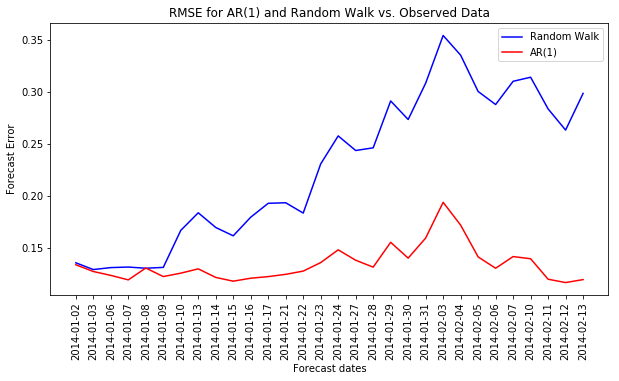

---------------------------------------------------
Initial date: 2013-12-24


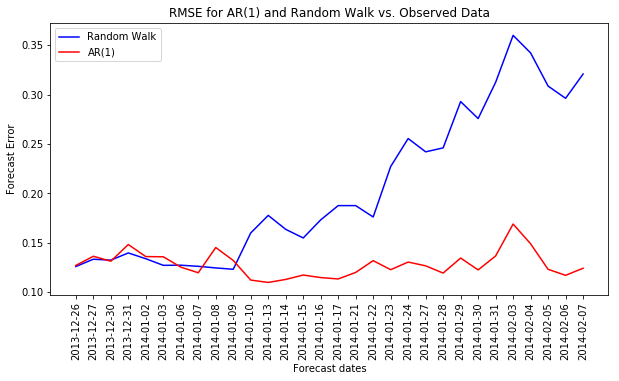

---------------------------------------------------
Initial date: 2013-12-27


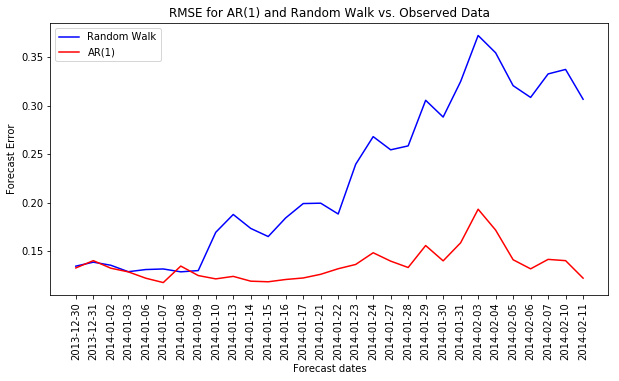

---------------------------------------------------
Initial date: 2014-01-02


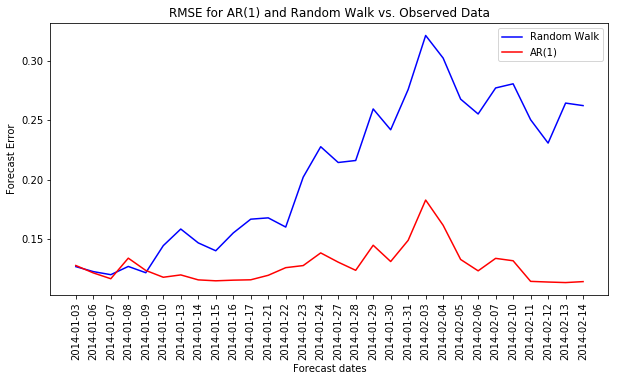

---------------------------------------------------
Initial date: 2013-12-30


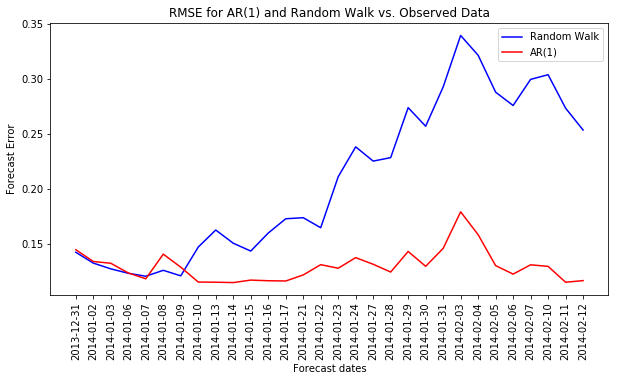

---------------------------------------------------
Initial date: 2014-01-03


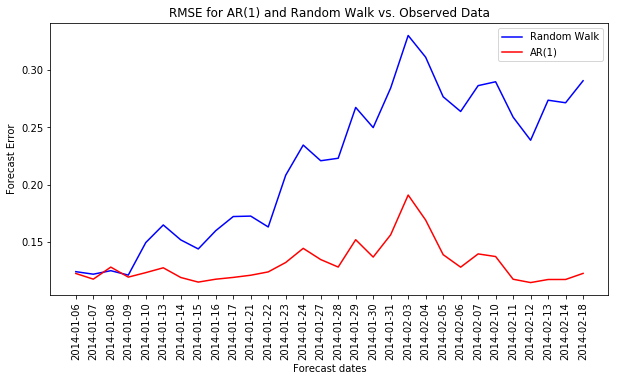

---------------------------------------------------
Initial date: 2013-12-23


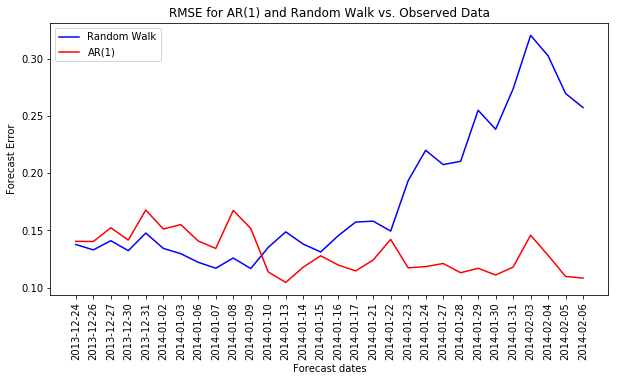

---------------------------------------------------
Initial date: 2013-12-19


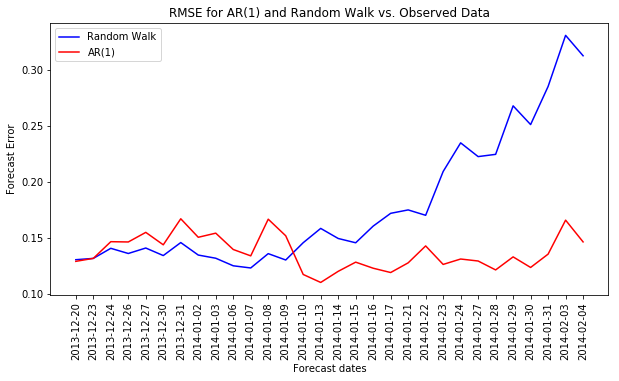

---------------------------------------------------
Initial date: 2013-12-26


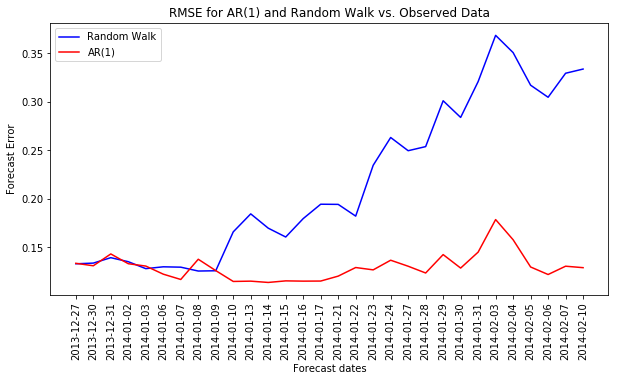

---------------------------------------------------
Initial date: 2013-12-20


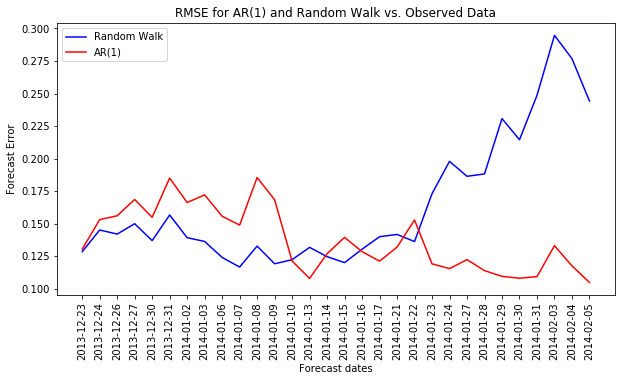

---------------------------------------------------
Initial date: 2014-04-21


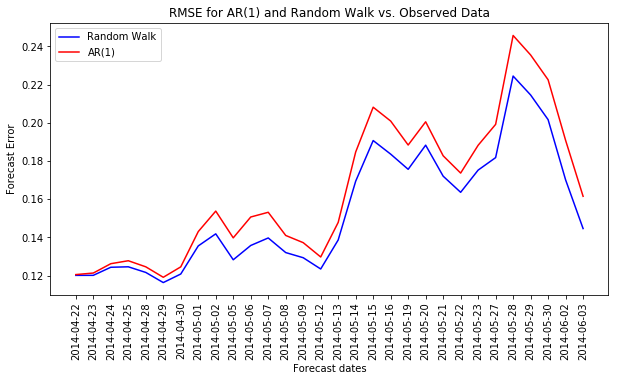

---------------------------------------------------
Initial date: 2014-01-08


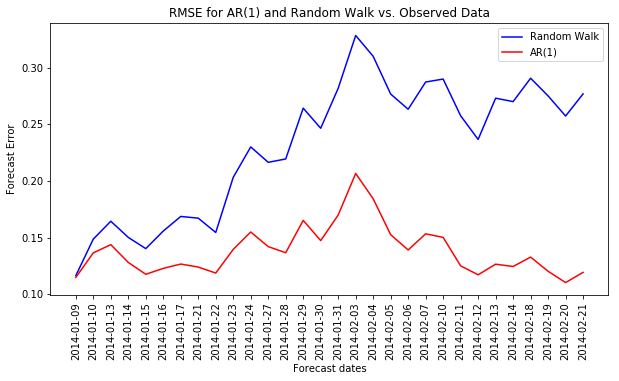

---------------------------------------------------
Initial date: 2014-01-06


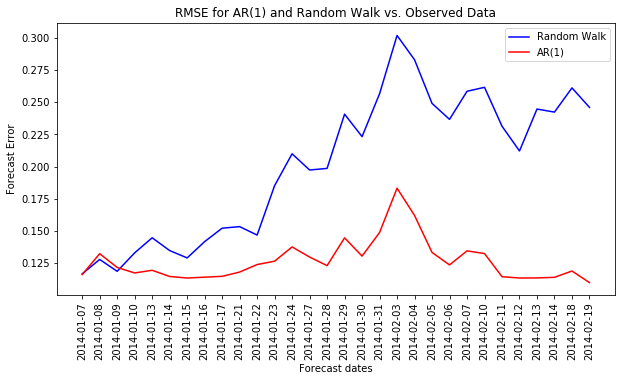

---------------------------------------------------
Initial date: 2014-04-24


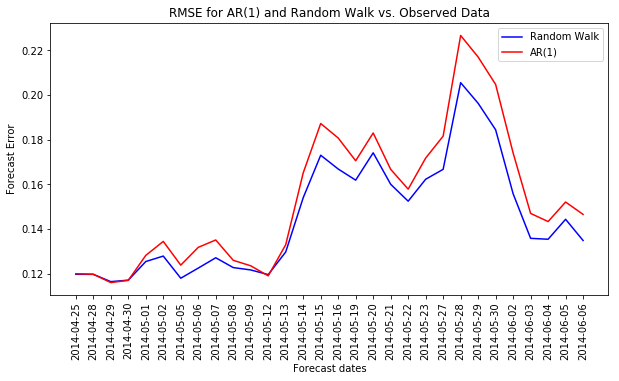

---------------------------------------------------
Initial date: 2014-04-17


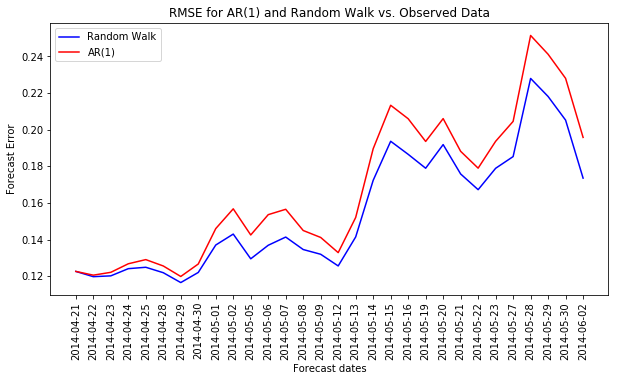

---------------------------------------------------
Initial date: 2014-04-22


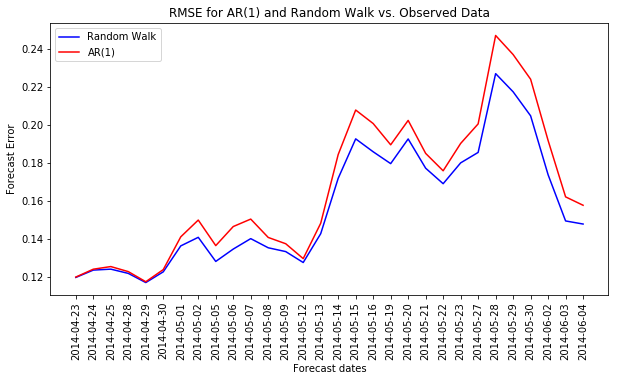

---------------------------------------------------
Initial date: 2014-04-28


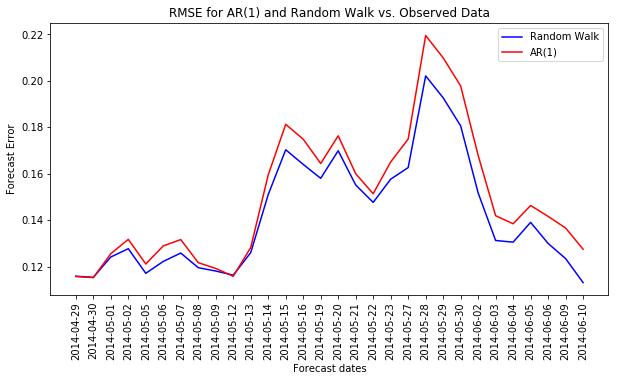

---------------------------------------------------
Initial date: 2014-04-25


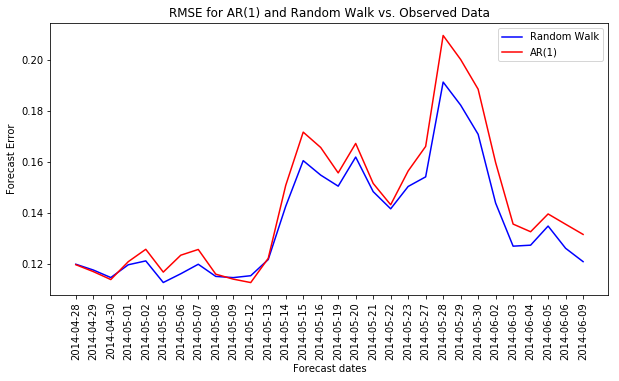

---------------------------------------------------
Initial date: 2014-04-23


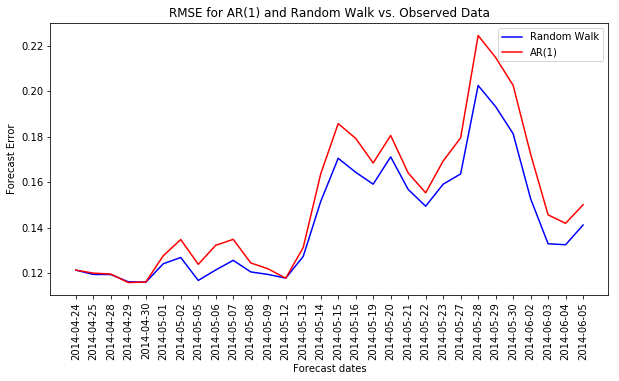

---------------------------------------------------
Initial date: 2014-04-03


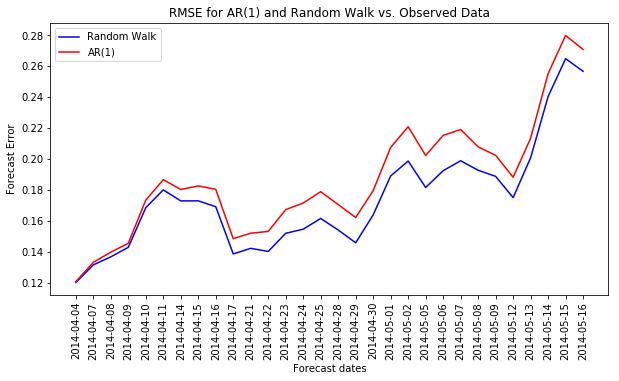

---------------------------------------------------


In [29]:
import warnings
warnings.filterwarnings('ignore')

for d in dt_index:
    df1=AR_1(df_betas, d.strftime('%Y-%m-%d'), n_days,0,1,0)
    df2=AR_1(df_betas, d.strftime('%Y-%m-%d'), n_days,1,0,0)
    
    ar_rw=df1[0].drop(d.strftime('%Y-%m-%d'), axis=0)
    ar_1=df2[0].drop(d.strftime('%Y-%m-%d'), axis=0)
    index=ar_rw.index

    rw_=[]
    ar1_=[] 
    
    for date in index:
        rw,ar1=forecast(date, optimal_lambda, cmt_terms,ar_rw,ar_1)
        actual=df.loc[date,:]
        ac_rw_=np.sqrt(mean_squared_error(actual,rw))
        ac_ar1_=np.sqrt(mean_squared_error(actual,ar1))
        rw_.append(ac_rw_)
        ar1_.append(ac_ar1_)

    rmse_= pd.DataFrame({"rw":rw_, "ar1":ar1_})
    rmse_.index=index
    
    print("Initial date: {}".format(d.strftime('%Y-%m-%d')))
    plt.figure(figsize=(10,5))
    plt.plot(rmse_.loc[:,"rw"], color="b", label="Random Walk")
    plt.plot(rmse_.loc[:,"ar1"], color="r", label="AR(1)")
    plt.ylabel("Forecast Error")
    plt.xlabel("Forecast dates")
    plt.xticks(rotation=90)
    plt.legend(loc=0)
    plt.title("RMSE for AR(1) and Random Walk vs. Observed Data")
    plt.show()
    print("---------------------------------------------------")

### 2013-12-31 date with the highest RMSE among the top 20

In [30]:
d="2013-12-31"
ar_rw=AR_1(df_betas, d, n_days,0,1,0)
ar_rw[0].loc[d,:]=ar_rw[0].loc[d,:]+df_betas.loc["2013-12-30"] #Initial value for Random Walk, drift+value from previous day
ar_1=AR_1(df_betas, d, n_days,1,0,0)

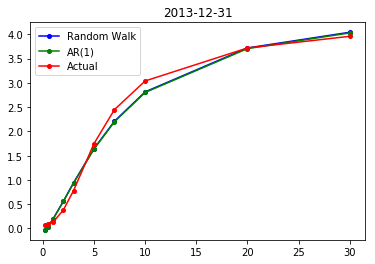

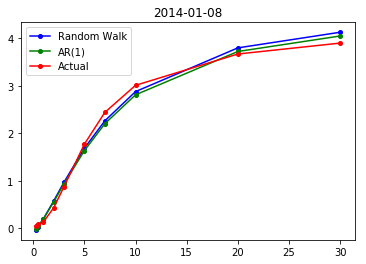

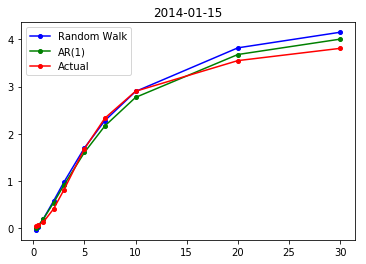

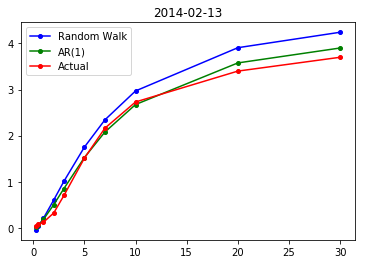

In [31]:
def plot(date):
    rw, ar1=forecast(date, optimal_lambda, cmt_terms, ar_rw[0], ar_1[0])
    plt.plot(cmt_terms,rw, "bo-", markersize=4, label="Random Walk")
    plt.plot(cmt_terms,ar1, "go-", markersize=4, label="AR(1)")
    plt.plot(cmt_terms,df.loc[date,:], "ro-", markersize=4, label="Actual")
    plt.title(date)
    plt.legend(loc=0)
    plt.show()

initial_date="2013-12-31"
t_5d="2014-01-08"
t_10d="2014-01-15"
t_1m="2014-02-13"

#Plots
plot(initial_date)
plot(t_5d)
plot(t_10d)
plot(t_1m)

### 2014-04-03 date with the lowest RMSE among the top 20

In [32]:
d="2014-04-03"
ar_rw=AR_1(df_betas, d, n_days,0,1,0)
ar_rw[0].loc[d,:]=ar_rw[0].loc[d,:]+df_betas.loc["2014-04-02"] #Initial value for Random Walk, drift+value from previous day
ar_1=AR_1(df_betas, d, n_days,1,0,0)

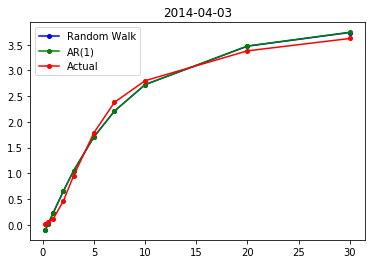

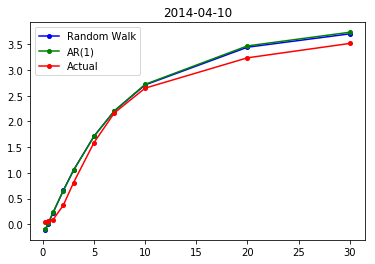

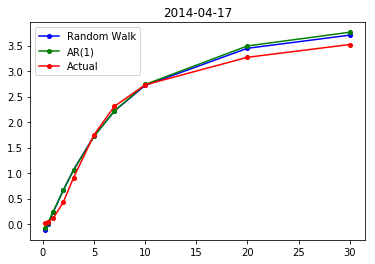

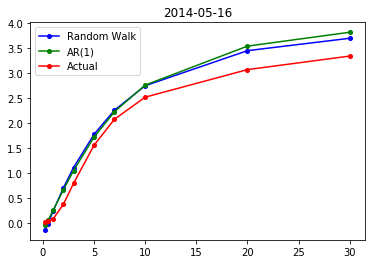

In [33]:
initial_date="2014-04-03"
t_5d="2014-04-10"
t_10d="2014-04-17"
t_1m="2014-05-16"

#Plots
plot(initial_date)
plot(t_5d)
plot(t_10d)
plot(t_1m)